# Part 2. DEAP Dataset + Spectral Analysis + SVM

In this part 2, we will focus on feature engineering using spectral analysis.  Spectral analysis here refers to the analysis of theta (4 - 8 Hz), alpha (8 - 12 Hz), beta (12 - 30 Hz), and gamma (30 - 64 Hz).   

Spectral analysis is a very basic and must-do analysis for emotions/cognitions/resting state since it is a common knowledge with abundant evidence that our emotion/cognition change how our brain signals oscillate.  For example, when we are calm, alpha is relatively high, likewise, when we are attentive, beta is relatively high and alpha becomes relatively lower.

In this part, we shall extract these powers as features and then input them into SVM and see if these features are useful for predicting the four valence-arousal classes that we have obtained from Part 1.

In [3]:
import torch

import os
import pickle
import numpy as np

Set cuda accordingly.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

Configured device:  cuda


## 1. Loading dataset

Let's first reuse the dataset loader we have created in Part 1.

In [5]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, path, stim):
        _, _, filenames = next(os.walk(path))
        filenames = sorted(filenames)
        all_data = []
        all_label = []
        for dat in filenames:
            temp = pickle.load(open(os.path.join(path,dat), 'rb'), encoding='latin1')
            all_data.append(temp['data'])
            
            if stim == "Valence":
                all_label.append(temp['labels'][:,:1])   #the first index is valence
            elif stim == "Arousal":
                all_label.append(temp['labels'][:,1:2]) # Arousal  #the second index is arousal
                
        self.data = np.vstack(all_data)[:, :32, ]   #shape: (1280, 32, 8064) --> take only the first 32 channels
        
        shape = self.data.shape
        
        #perform segmentation=====
        segments = 12
        
        self.data = self.data.reshape(shape[0], shape[1], int(shape[2]/segments), segments)
        #data shape: (1280, 32, 672, 12)

        self.data = self.data.transpose(0, 3, 1, 2)
        #data shape: (1280, 12, 32, 672)

        self.data = self.data.reshape(shape[0] * segments, shape[1], -1)
        #data shape: (1280*12, 32, 672)
        #==========================
        
        self.label = np.vstack(all_label) #(1280, 1)  ==> 1280 samples, 
        self.label = np.repeat(self.label, 12)[:, np.newaxis]  #the dimension 1 is lost after repeat, so need to unsqueeze (1280*12, 1)
        
        del temp, all_data, all_label

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        single_data  = self.data[idx]
        single_label = (self.label[idx] > 5).astype(float)   #convert the scale to either 0 or 1 (to classification problem)
        
        batch = {
            'data': torch.Tensor(single_data),
            'label': torch.Tensor(single_label)
        }
        
        return batch

Let's try load the dataset.

In [6]:
path = "data"  #create a folder "data", and inside put s01.dat,....,s32.dat inside from the preprocessed folder from the DEAP dataset

In [8]:
dataset = Dataset(path, "Valence")

data  = dataset[:]['data']
label = dataset[:]['label']

print("Data shape: " , data.shape)  #15360 = 32 participants * 40 trials * 12 segments, 32 EEG channels, 672 samples
print("Label shape: ", label.shape)  #two classes of valence
print(f"{sum(label==0)=} + {sum(label==1)=} = {sum(label==0)+sum(label==1)}")

del(data,label)

Data shape:  torch.Size([15360, 32, 672])
Label shape:  torch.Size([15360, 1])
sum(label==0)=tensor([6864]) + sum(label==1)=tensor([8496]) = tensor([15360])


## 2. Spectral Analysis

Recall to the [dataset meta data ](https://www.eecs.qmul.ac.uk/mmv/datasets/deap/readme.html#prep), the following information is relevant to us.

- sample rate: 128Hz
- Channels: 32
  1.	Fp1	
  2.	AF3
  3.	F3
  4.	F7
  5.	FC5
  6.	FC1
  7.	C3
  8.	T7
  9.	CP5
  10.	CP1
  11.	P3
  12.	P7
  13.	PO3
  14.	O1
  15.	Oz
  16.	Pz
  17.	Fp2
  18.	AF4
  19.	Fz
  20.	F4
  21.	F8
  22.	FC6
  23.	FC2
  24.	Cz
  25.	C4
  26.	T8
  27.	CP6
  28.	CP2
  29.	P4
  30.	P8
  31.	PO4
  32.	O2

For this task, we wil be using [Python MNE library](https://mne.tools/stable/index.html)

In [9]:
import mne
mne.sys_info()
# Note that at the time this jupytor is created, the version of MNE is 0.24.1

# Additional library that I use are
# - sklearn
# - psutil
# - pandas
# - matplotlib
# Their version is as followed

Platform:       Linux-5.10.16.3-microsoft-standard-WSL2-x86_64-with-glibc2.29
Python:         3.8.10 (default, Nov 26 2021, 20:14:08)  [GCC 9.3.0]
Executable:     /root/projects/.venv/bin/python
CPU:            x86_64: 16 cores
Memory:         15.4 GB

mne:            0.24.1
numpy:          1.22.3 {}
scipy:          1.8.0
matplotlib:     3.5.1 {backend=module://matplotlib_inline.backend_inline}

sklearn:        1.0.2
numba:          Not found
nibabel:        Not found
nilearn:        Not found
dipy:           Not found
cupy:           Not found
pandas:         1.4.1
mayavi:         Not found
pyvista:        Not found
pyvistaqt:      Not found
ipyvtklink:     Not found
vtk:            Not found
PyQt5:          Not found
ipympl:         Not found
mne_qt_browser: Not found
pooch:          Not found


First, you need to understand MNE philosophy.

In EEG-like experiment, you usually have a session. (1 record)

The data you usually have is in a form of (channels, samples)

For instance, if you record EEG with 16 channels, sample rate of 128 Hz, and 5 seconds long then you would end up with a session in a shape of (16, 128 x 5). Sort of.

It is very common that we also have addition channels like EOG, ECG, MEG, EMG, and many more ..G so the number of channel can be vary. One addition channel we record is `marker`.

A `marker` is sort of mapper during the record to later identify when does something happen.

For instance, if you are recording an EEG data that a participant watch a series of images. You might want to also embeded the information when does the image change or even better, the current shown show.

Let's say there is two images. A data with 3 EEG chanels + marker will might look like this

```
[
 .
 .
 .
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 1], <----- The image 1 is shown now
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 2], <----- The image 2 is shown now
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 [eeg_1, eeg_2, eeg_3, 0],
 .
 .
 .
]
```


When you load the data to MNE, there are three data structures MNE has which corresponding to the analysis needs.

https://mne.tools/stable/most_used_classes.html

1. MNE.io.Raw
2. MNE.Epochs
3. MNE.Evoked

The `MNE.io.Raw`



The idea is to create a `mne.raw` data. https://mne.tools/stable/generated/mne.io.Raw.html

Base on the Dataset we have created, the data are in a form of `epochs`. (15360 epochs, 32 channels, 672 samples)

Luckily, MNE has a function to create a `mne.raw` from the epochs data. https://mne.tools/stable/generated/mne.EpochsArray.html#mne.EpochsArray

In [10]:
ch_names = ['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2']
ch_types = ['eeg'] * len(ch_names)
sfreq = 128 #Hz
# https://mne.tools/stable/generated/mne.create_info.html
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)
epochs = mne.EpochsArray(dataset[:]['data'],info)
epochs.set_montage('standard_1020')
print('----')
print(epochs)
print('----')
# You can access the original data using <>._data 
print(f"{epochs._data.shape=}")

Not setting metadata
Not setting metadata
15360 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
----
<EpochsArray |  15360 events (all good), 0 - 5.24219 sec, baseline off, ~2.46 GB, data loaded,
 '1': 15360>
----
epochs._data.shape=(15360, 32, 672)


Base on the information given in the DEAP website, the preprocessed data has done the following;

1. The data was downsampled to 128Hz.
2. EOG artefacts were removed as in [1].
3. A bandpass frequency filter from 4.0-45.0Hz was applied.
4. The data was averaged to the common reference.
5. The EEG channels were reordered so that they all follow the Geneva order as above.
6. The data was segmented into 60 second trials and a 3 second pre-trial baseline removed.
7. The trials were reordered from presentation order to video (Experiment_id) order.

In [26]:
epochs.__getitem__(0)._data.shape

(1, 32, 672)

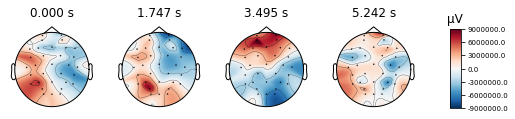

Creating RawArray with float64 data, n_channels=32, n_times=672
    Range : 0 ... 671 =      0.000 ...     5.242 secs
Ready.
Effective window size : 5.250 (s)


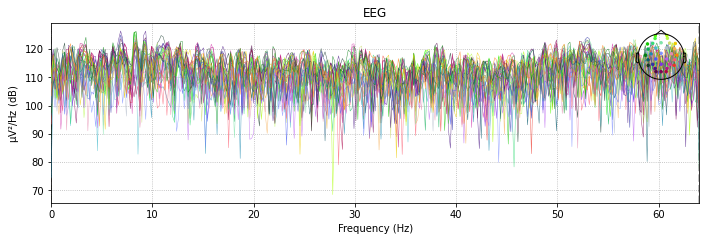

    Using multitaper spectrum estimation with 7 DPSS windows


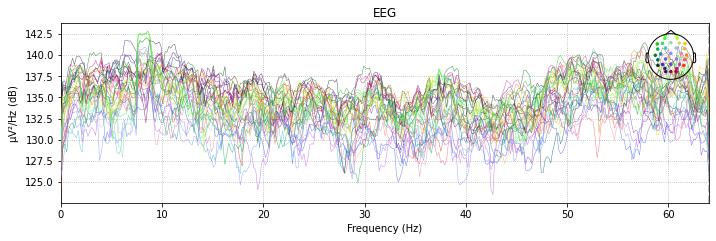

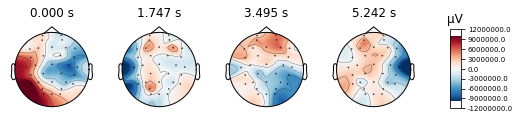

Creating RawArray with float64 data, n_channels=32, n_times=672
    Range : 0 ... 671 =      0.000 ...     5.242 secs
Ready.
Effective window size : 5.250 (s)


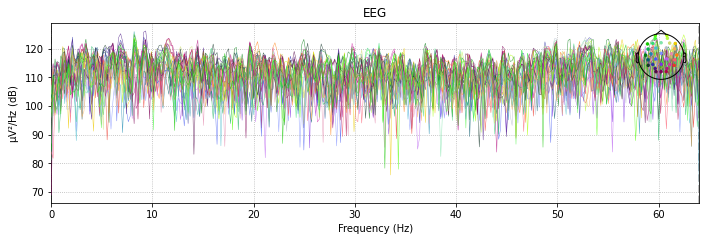

    Using multitaper spectrum estimation with 7 DPSS windows


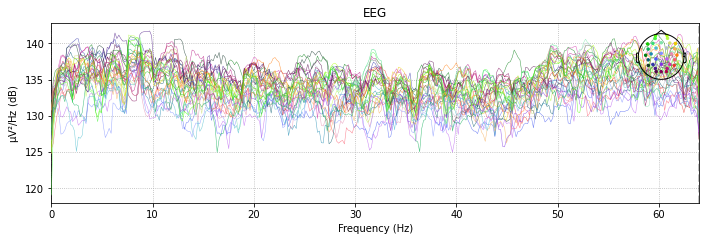

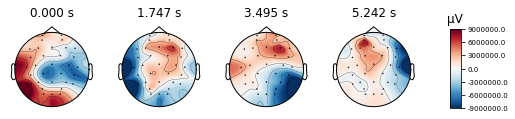

Creating RawArray with float64 data, n_channels=32, n_times=672
    Range : 0 ... 671 =      0.000 ...     5.242 secs
Ready.
Effective window size : 5.250 (s)


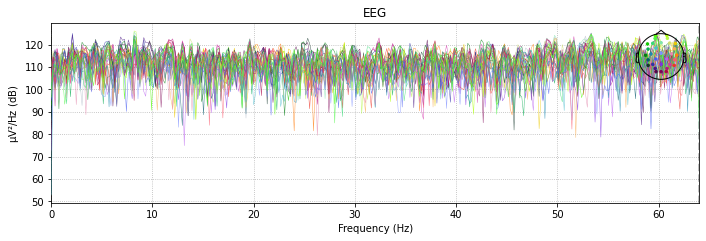

    Using multitaper spectrum estimation with 7 DPSS windows


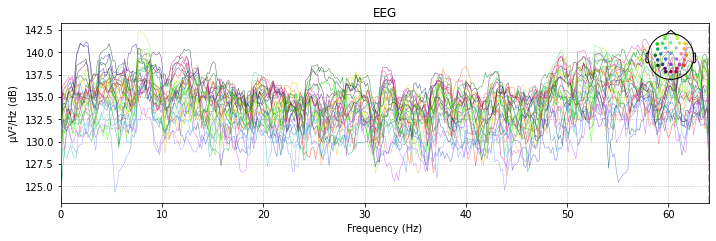

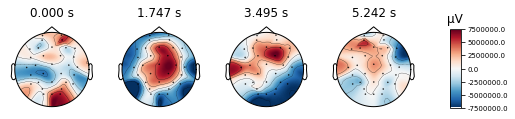

Creating RawArray with float64 data, n_channels=32, n_times=672
    Range : 0 ... 671 =      0.000 ...     5.242 secs
Ready.
Effective window size : 5.250 (s)


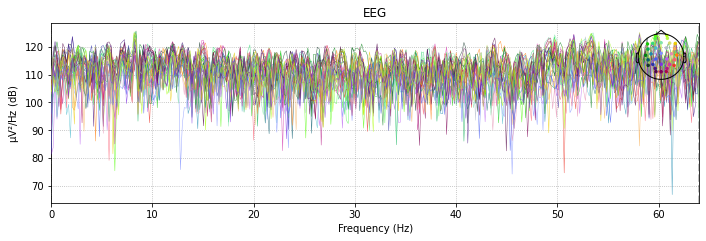

    Using multitaper spectrum estimation with 7 DPSS windows


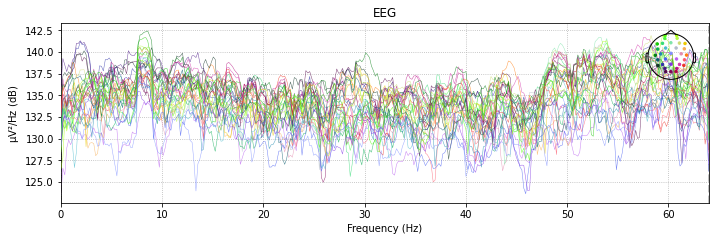

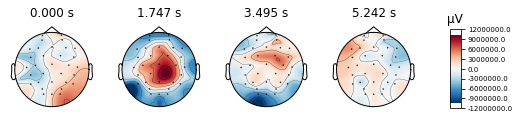

Creating RawArray with float64 data, n_channels=32, n_times=672
    Range : 0 ... 671 =      0.000 ...     5.242 secs
Ready.
Effective window size : 5.250 (s)


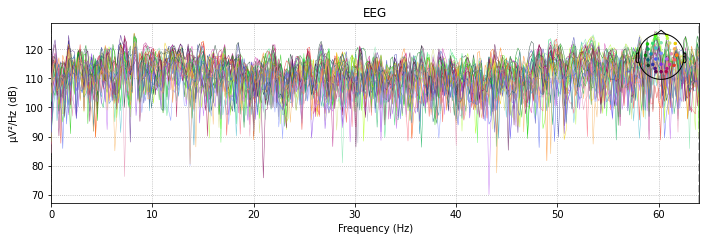

    Using multitaper spectrum estimation with 7 DPSS windows


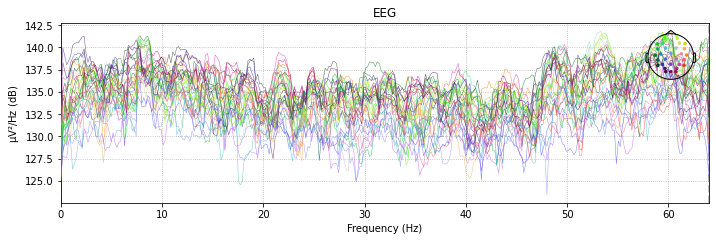

In [32]:
# count = 0
for evoked in epochs.iter_evoked():
    evoked.plot_topomap()
    raw = mne.io.RawArray(evoked.get_data(),info=info)
    raw.set_montage('standard_1020')
    raw.plot_psd()
    epochs.__getitem__(count).plot_psd()

Let's take a look at the raw signal.

===== 0 =====
    Using multitaper spectrum estimation with 7 DPSS windows


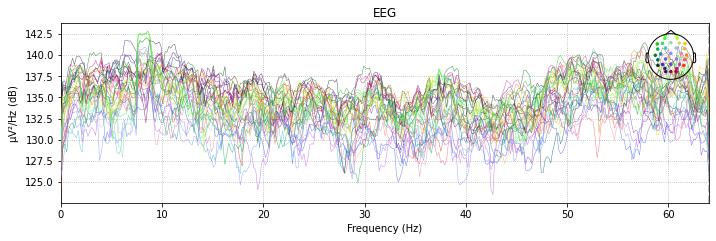

===== 1 =====
    Using multitaper spectrum estimation with 7 DPSS windows


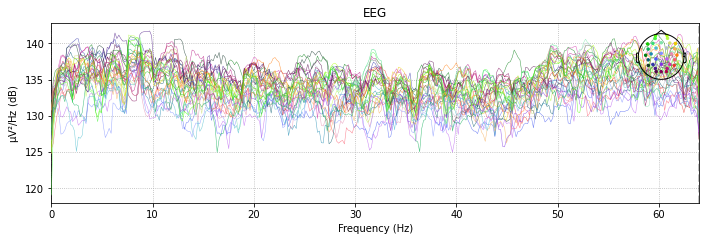

===== 2 =====
    Using multitaper spectrum estimation with 7 DPSS windows


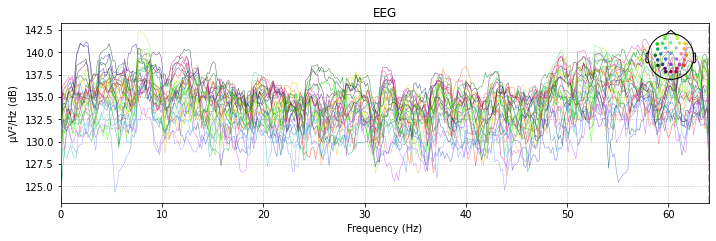

===== 3 =====
    Using multitaper spectrum estimation with 7 DPSS windows


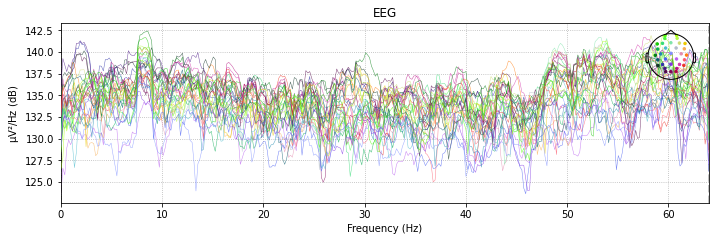

===== 4 =====
    Using multitaper spectrum estimation with 7 DPSS windows


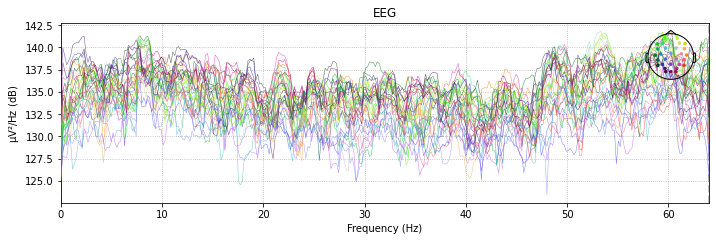

In [29]:
for index in range(5):
    print("="*5,index,"="*5)
    raw = epochs.__getitem__(index)
    _ = raw.plot_psd()

===== 0 =====


/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: Deprecat

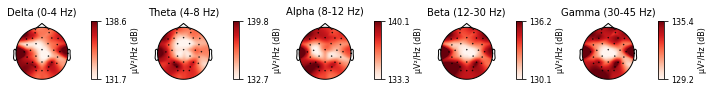

===== 1 =====


/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: Deprecat

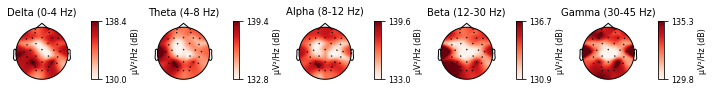

===== 2 =====


/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: Deprecat

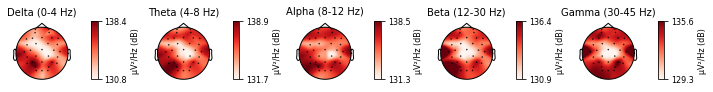

===== 3 =====


/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: Deprecat

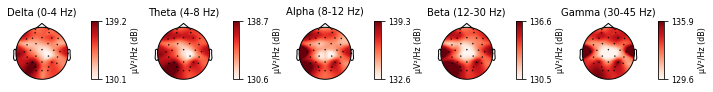

===== 4 =====


/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/root/projects/.venv/lib/python3.8/site-packages/mne/utils/check.py:92: Deprecat

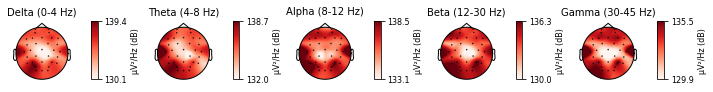

In [31]:
for index in range(5):
    print("="*5,index,"="*5)
    raw = epochs.__getitem__(index)
    _ = raw.plot_psd_topomap(verbose=False)
    # _ = raw.pl

===== 0 =====


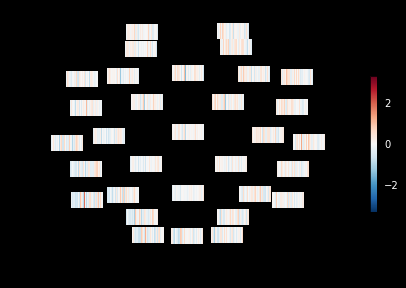

===== 1 =====


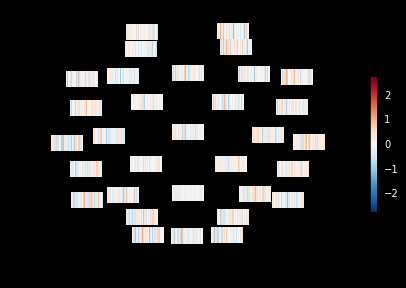

===== 2 =====


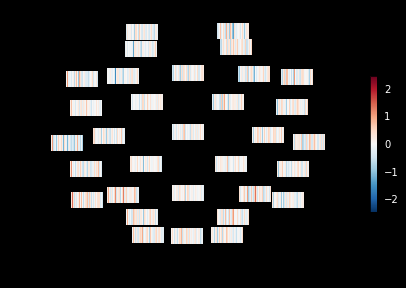

===== 3 =====


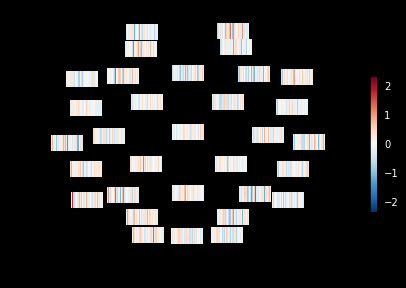

===== 4 =====


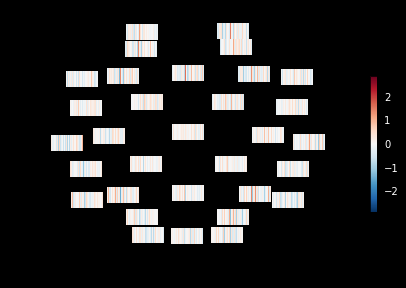

In [34]:
for index in range(5):
    print("="*5,index,"="*5)
    raw = epochs.__getitem__(index)
    raw.plot_topo_image()
    # _ = raw.plot_psd_topomap(verbose=False)
    # _ = raw.pl

## 3. Machine Learning

In [13]:
sum(label==0) + sum(label==1)

tensor([15360])